# Código para a segmentação de dados de um dataframe

O primeiro passo é importar os dados de um arquivo .csv

O exemplo usado para isso é o arquivo run8.csv, que possui dados emg medidos, além da alguns dados inerciais. 
Como, por enquanto, só nos interessa o valor EMG medido, ao se ler o csv, utiliza-se apenas as colunas do tempo de medição, que vai servir como índicie, e do emg medido. 

Utiliza-se uma frequência de 1000Hz para a coleta dos dados, o que fornece 1 amostra por milissegundo. O tempo total da coleta é feito por 21,6 segundos, totalizando 21600 medições. 

In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv

series = read_csv('run6.csv', header=32, usecols = [0,1], index_col = 0)
series.head()

,Avanti Sensor 1: EMG 1 [V]
X [s],
0.000,-0.000817
0.001,-0.004815
0.002,-0.008836
0.003,-0.010983
0.004,-0.010845


# Indexação dos dados

Ao ler o csv, o framework pandas já converte os dados em um DataFrame. Este DataFrame, como visto acima, utiliza como índice o tempo da medição (em ms) e a colunda de dados é a medição EMG (em Volts). 

Porém, as funções que vão ser usadas a seguir não entendem os valores do índice na forma que foram lidos, e por isso deve-se fazer uma conversão dos dados para que sejam entendidos

In [3]:
series.index = pd.to_datetime(series.index, unit = 's', origin= 'unix')
series.index = series.index.map(lambda t: t.replace(year=2021, month=10, day=12, hour=10))
series.index = pd.DatetimeIndex(series.index).to_period('L')
series.head()

,Avanti Sensor 1: EMG 1 [V]
X [s],
2021-10-12 10:00:00.000,-0.000817
2021-10-12 10:00:00.001,-0.004815
2021-10-12 10:00:00.002,-0.008836
2021-10-12 10:00:00.003,-0.010983
2021-10-12 10:00:00.004,-0.010845


# Segmentação dos Dados

$$
N\; janelas = \frac{tamanho\: dos\,dados - tamanho\, da\, janela}{incremento\, da\,janela} + 1
$$

In [3]:
# osw = series.rollling(window = 5, step = 2)
# series.rolling(window = 5).
data_size = len(series)
window_size = 250
window_overlap = 50

n_windows = (data_size - window_size)/window_overlap + 1

# osw = series.copy()
# osw2 = osw[1:5]
# osw2
# print(data_size, window_size, window_overlap, n_windows)
osw = []
for i in range(int(n_windows)):
    osw.append( series[(i*window_overlap):(i*window_overlap + window_size)])

osw[10]

,Avanti Sensor 1: EMG 1 [V]
X [s],
2021-10-12 10:00:00.500,-0.000013
2021-10-12 10:00:00.501,-0.000010
2021-10-12 10:00:00.502,0.000000
2021-10-12 10:00:00.503,-0.000008
2021-10-12 10:00:00.504,-0.000023
...,...
2021-10-12 10:00:00.745,0.009666
2021-10-12 10:00:00.746,0.010226
2021-10-12 10:00:00.747,0.010154


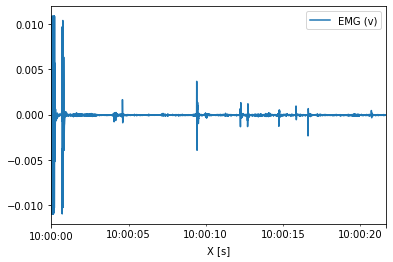

In [4]:
%matplotlib inline
from matplotlib import pyplot
series.plot()
pyplot.legend(['EMG (v)'])

# Teste ADFULLER para testar estacionaridade

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(osw[21].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Contruindo modelo ARIMA

In [6]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(osw[10], order = (4,0,0))
model_fit = model.fit()
print(model_fit.summary())

                                   SARIMAX Results                                    
Dep. Variable:     Avanti Sensor 1: EMG 1 [V]   No. Observations:                  250
Model:                         ARIMA(4, 0, 0)   Log Likelihood                1403.670
Date:                        Fri, 15 Oct 2021   AIC                          -2795.340
Time:                                17:16:51   BIC                          -2774.211
Sample:                            10-12-2021   HQIC                         -2786.836
                                 - 10-12-2021                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.204      0.838      -0.002       0.002
ar.L1          1.5806      0.045     35.247      0.000       1.493 

# Plotando erros residuais

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = pyplot.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
pyplot.show()

# Predição

NameError: name 'pyplot' is not defined

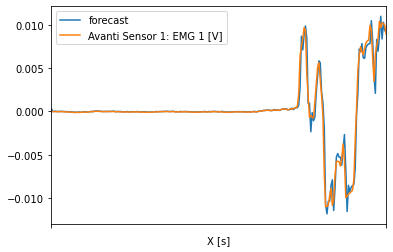

In [5]:


# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
pyplot.show()

# import statsmodels
# statsmodels.__version__



In [7]:
feature_vector = []
feature_vector.append(model_fit.polynomial_ar)
# feature_vector = np.delete(feature_vector, 0)
# feature_vector = -feature_vector
# np.delete(model_fit.polynomial_ar, 0)
print(feature_vector)

[array([ 1.        , -1.58058025,  0.81049699, -0.28006644,  0.1108924 ])]


In [ ]:
%lsmagic